<a href="https://colab.research.google.com/github/wendywtchang/NLP-projects/blob/master/topic_modeling/Bert_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using BERT for Topic Modeling
- https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6
- What is Topic Modeling?
- Which topic can frequently be found in these documents?
- Frequent Models: LDA, NMF (it took some effort through hyperparameter tuning to create meaningful topics.)
- [Top2Vec](https://github.com/ddangelov/Top2Vec): leverage document and word embeddings to create topics that were easily interpretable
- [BERTopic](https://arxiv.org/abs/2008.09470)
- How to use BERT to create your own topic model?

## 1. Data Loading

In [1]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')['data']
# data = fetch_20newsgroups(subset='train')['data'] for smaller dataset

In [2]:
!pip install sentence-transformers

     |████████████████████████████████| 79 kB 5.6 MB/s 
     |████████████████████████████████| 3.5 MB 46.5 MB/s 
     |████████████████████████████████| 1.2 MB 51.0 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 596 kB 49.0 MB/s 
     |████████████████████████████████| 6.8 MB 56.9 MB/s 
     |████████████████████████████████| 895 kB 57.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=497496b20aa7b2ad51ab9b5e692f6727bf2cd58b1f8ac558767b70429fa690ca
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## 2. Embeddings

In [3]:
# Distilbert gives a nice balance between speed and performance
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

## 3. Clustering
- Documents with similar topics should be clustered together
- We first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly

### 3.1 Reduce Dimentionality
- UMAP: One of the best performance dimensionality reduction algorithms, it keeps a significant portion of the high-dimensional local structure in lower dimensionality.

- NOTE: You could skip the dimensionality reduction step if you use a clustering algorithm that can handle high dimensionality like a cosine-based k-Means.

In [4]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 3.8 MB/s 
     |████████████████████████████████| 1.1 MB 43.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=445a92f183386d9b556111e703b635b44613a6cd556551cc8d98152cf4bbd0ff
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=f01b2137705b044d619c9916f7aa6c2f042b4c76fc3fc85189db1ea06f3d84cb
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


- We reduce the dimensionality to 5 while keeping the size of the local neighborhood at 15. You can play around with these values to optimize for your topic creation. 

- Note that a too low dimensionality results in a loss of information while a too high dimensionality results in poorer clustering results.

In [5]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


### 3.2 Cluster documents with HDBSCAN
- HDBSAN: a density-based algorithm that works quite well with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space.
- It does not force data points to clusters as it considers them outliers.
- After reduce the dimentionality to 5, we cluster the documents with HDBSCAN

In [6]:
!pip install hdbscan

     |████████████████████████████████| 5.2 MB 7.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330760 sha256=b10cc7c3ebe841ef24059202f2004a5a5d1bdb58c29b8d4eaa5b980373a388f4
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan


In [7]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

## 4. Visualization
- How to explain the visualization plot?


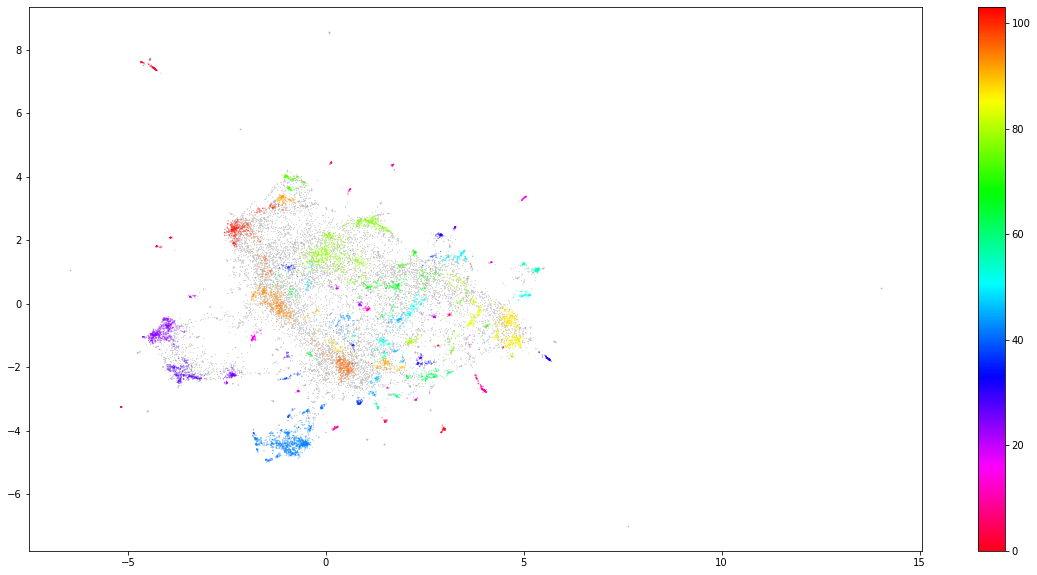

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

## 5. Topic Creation
- How can we derive topics from clustered documents?
- a class-based variant of TF-IDF (c-TF-IDF), that would allow me to extract what makes each set of documents unique compared to the other.
- When you apply TF-IDF as usual on a set of documents, what you are basically doing is comparing the importance of words between documents.

In [10]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [11]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

a single importance value for each word in a cluster which can be used to create the topic.

### 5.1 Topic Representation

In [12]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,11335
43,42,851
79,78,570
25,24,472
28,27,265
97,96,234
78,77,226
95,94,217
88,87,205
103,102,180


In [16]:
# Space news?
top_n_words[42][:10]

[('nasa', 0.02157835769882443),
 ('space', 0.017044340666091763),
 ('gov', 0.014219183846623028),
 ('henry', 0.010660253387207828),
 ('launch', 0.008858511557132211),
 ('jpl', 0.008710394935143717),
 ('moon', 0.008381876505062924),
 ('orbit', 0.007424449822704556),
 ('earth', 0.007343933034289062),
 ('spacecraft', 0.007113782582129416)]

In [17]:
# Computer products?
top_n_words[78][:10]

[('windows', 0.010763325262150559),
 ('problem', 0.00850664168541466),
 ('dos', 0.007799320028336582),
 ('disk', 0.00742741321068537),
 ('thanks', 0.006989073199018788),
 ('help', 0.006923552473429861),
 ('error', 0.0064324559710587665),
 ('file', 0.00604259274601735),
 ('program', 0.005998282000985512),
 ('screen', 0.005875473002288468)]

In [18]:
# Sport game news?
top_n_words[24][:10]

[('baseball', 0.017590636523980668),
 ('game', 0.014091041617700679),
 ('03', 0.013077239303512476),
 ('02', 0.011357188023406769),
 ('04', 0.010679159806501044),
 ('games', 0.010254985916246654),
 ('players', 0.010232801185468066),
 ('runs', 0.009974009594365315),
 ('braves', 0.009843428387640466),
 ('cubs', 0.009018471320300286)]

### 5.2 Topic Reduction

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

,Topic,Size
0,-1,11355
33,32,851
65,64,625
18,17,472
21,20,265
64,63,262
80,79,234
78,77,217
71,70,212
72,71,205
